In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
# print folder directory
print(os.getcwd())

/Users/omer/Library/CloudStorage/GoogleDrive-omerulfaruk97@gmail.com/My Drive/MyReposDrive/obsidian_Notes/Landy Omer Re 1/av-dur-estimation


In [3]:
# function for loading data
def loadData(dataName):
    data = pd.read_csv("data/"+dataName)
    #data['avgAVDeltaS'] = (data['deltaDurS'] + (data['recordedDurVisualTest'] - data['recordedDurVisualStandard'])) / 2
    #data['deltaDurPercentVisual'] = ((data['recordedDurVisualTest'] - data['recordedDurVisualStandard']) / data['recordedDurVisualStandard'])
    #data['avgAVDeltaPercent'] = data[['delta_dur_percents', 'deltaDurPercentVisual']].mean(axis=1)

    # Define columns for chosing test or standard
    data['chose_test'] = (data['responses'] == data['order']).astype(int)
    data['chose_standard'] = (data['responses'] != data['order']).astype(int)
    data = data[data['audNoise'] != 0]
    data['visualPSEBias'] = data['recordedDurVisualStandard'] -data["standardDur"]-data['conflictDur']
    data['conflictDur'] = data['conflictDur'].round(2)
    data['standard_dur']=data['standardDur']

    try:
        data["riseDur"]>1
    except:
        data["riseDur"]=1

    data['standard_dur']=round(data['standardDur'],2)
    data["delta_dur_percents"]=round(data["delta_dur_percents"],2)
    data['conflictDur']=round(data['conflictDur'],2)

    data=data[data['recordedDurVisualStandard'] <=998]
    data=data[data['recordedDurVisualStandard'] >=0]

    return data


In [51]:
dataName="HH_auditoryDurEst_2025-05-23_11h40.57.375.csv"
"oy_all_mainExpAvDurEstimate_2025-04-19_10h46.57.737.csv"
"HH_bimodalDurEst_2025-05-23_12h07.33.994.csv"
# Load the data
data = loadData(dataName)

In [52]:
#intensityVariable="avgAVDeltaS"
#intensityVariable="avgAVDeltaPercent"
#intensityVariable="deltaDurS"
#intensityVariable="deltaDurPercentVisual"
intensityVariable="delta_dur_percents"
#intensityVariable="avgAVDeltaS"

# Get unique conditions


In [53]:
sensoryVar="audNoise"
standardVar="standardDur"
conflictVar="conflictDur"

data[standardVar] = round(data[standardVar], 2)
uniqueSensory = data[sensoryVar].unique()
uniqueStandard = data[standardVar].unique()
uniqueConflict = sorted(data[conflictVar].unique())
print(f"uniqueSensory: {uniqueSensory} \n uniqueStandard: {uniqueStandard} \n uniqueConflict: {uniqueConflict}")

nLambda=len(uniqueStandard)
nSigma=len(uniqueSensory)
nMu=len(uniqueConflict)*nSigma
print(f"nLambda: {nLambda} \n nSigma: {nSigma} \n nMu: {nMu}")

uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [0.0]
nLambda: 1 
 nSigma: 2 
 nMu: 2


In [54]:
nSensoryVar = len(uniqueSensory)
nConflictVar = len(uniqueConflict)
print(f"nSensoryVar: {nSensoryVar} \n nConflictVar: {nConflictVar}")

nSensoryVar: 2 
 nConflictVar: 1


In [55]:

def createParamVector(data, standardVar,sensoryVar,conflictVar):
    """
    Create a parameter vector for the data.
    """
    nLambda=len(uniqueStandard)   
    nSigma=len(uniqueSensory)*len(uniqueConflict)
    nMu=len(uniqueConflict)*nSigma
    paramMatrix = np.zeros((nMu, 3))

    nParams=nLambda+nSigma+nSigma*(nMu/nSigma)
    print(f"nParams: {nParams}")
    # Create the parameter vector
    for i, standard in enumerate(uniqueStandard):
        for j, sensory in enumerate(uniqueSensory):
            for k, conflict in enumerate(uniqueConflict):
                # Calculate the index for the parameter vector
                index = i * nSigma + j * len(uniqueConflict) + k
                # Assign the values to the parameter vector
                paramMatrix[index, 0] = standard
                paramMatrix[index, 1] = sensory
                paramMatrix[index, 2] = conflict
    
    paramMatrix = pd.DataFrame(paramMatrix, columns=[standardVar, sensoryVar, conflictVar])
    paramVector= [0]*int(nParams)
    return paramVector, paramMatrix, nLambda, nSigma, nMu


In [56]:

params,paramMatrix,nLambda, nSigma, nMu=createParamVector(data,standardVar,sensoryVar,conflictVar)


nParams: 5.0


In [57]:

def initGuessesF(paramVector,nStarts):
    """
    Initialize the guesses for the parameters.
    """
    # Initialize the guesses for the parameters
    #lambda guesses
    for i in range(nLambda):
        paramVector[i] = np.linspace(0, 0.2, nStarts)
    #sigma guesses
    for i in range(nLambda, nLambda+nSigma):
        paramVector[i] = np.linspace(0.05, 1, nStarts)  # Different initial guesses for sigma
    #mu guesses
    for i in range(nLambda+nSigma, nLambda+nSigma+nMu):
        paramVector[i] =np.linspace(-0.15, 0.15, nStarts)  # Different initial guesses for mu
    
    return np.array(paramVector)
initGuessesMatrix = initGuessesF(params, 2)

# Group data

In [58]:

def groupByChooseTest(x):
    grouped = x.groupby([intensityVariable, sensoryVar, standardVar,conflictVar]).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum'),
    ).reset_index()
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']

    return grouped

groupedData= groupByChooseTest(data)

In [59]:
# Compute sigma from slope
def compute_sigma_from_slope(slope, lapse_rate=0.02):
    sigma = (1 - lapse_rate) / (np.sqrt(2 * np.pi) * slope)*np.exp(-0.5)
    return sigma

def bin_and_plot(data, bin_method='cut', bins=10, bin_range=None, plot=True,color="blue"):
    if bin_method == 'cut':
        data['bin'] = pd.cut(data[intensityVariable], bins=bins, labels=False, include_lowest=True, retbins=False)
    elif bin_method == 'manual':
        data['bin'] = np.digitize(data[intensityVariable], bins=bin_range) - 1
    
    grouped = data.groupby('bin').agg(
        x_mean=(intensityVariable, 'mean'),
        y_mean=('p_choose_test', 'mean'),
        total_resp=('total_responses', 'sum')
    )

    if plot:
        plt.scatter(grouped['x_mean'], grouped['y_mean'], s=grouped['total_resp']/data['total_responses'].sum()*900, color=color)

from scipy.stats import linregress
def estimate_initial_guesses(levels,chooseTest,totalResp):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    intensities = levels
    chose_test = chooseTest
    total_resp = totalResp
    
    # Compute proportion of "chose test"
    proportions = chose_test / total_resp
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(intensities, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(intensities)) - np.abs(min(intensities))
    
    return [lapse_rate_guess, mu_guess, sigma_guess]

single_init_guesses = estimate_initial_guesses(
    groupedData[intensityVariable],
    groupedData['num_of_chose_test'],
    groupedData['total_responses']
)
print("Initial guesses:", single_init_guesses)

Initial guesses: [0.03, 0.233398734088341, 0.4619813398202153]


# Get Parameters

In [60]:
from tqdm import tqdm

def get_params(params, conflict, audio_noise, nLambda, nSigma):

    # Get lambda (lapse rate)
    lambda_ = params[0]    
    # Get sigma based on noise level
    
    # Get noise index safely
    noise_idx_array = np.where(uniqueSensory == audio_noise)[0]
    if len(noise_idx_array) == 0:
        raise ValueError(f"audio_noise value {audio_noise} not found in uniqueSensory.")
    
    # Get conflict index safely
    conflict_idx_array = np.where(uniqueConflict==conflict)[0]
    if len(conflict_idx_array) == 0:
        raise ValueError(f"conflict value {conflict} not found in uniqueConflict.")
    conflict_idx = conflict_idx_array[0]
    
    noise_idx = noise_idx_array[0]
    
    # sigma is after lambda, so we need to find its index
    sigma = params[(conflict_idx)*(noise_idx+1) + 1]  # +1 because lambda is first 
    

    noise_offset = noise_idx * len(uniqueConflict)
    #print(f"noise_idx: {noise_idx}, conflict_idx: {conflict_idx}, noise_offset: {noise_offset}, lenParams: {len(params)}")
    # mu is after lambda and sigma, so we need to find its index
    #mu_idx = nLambda+ nSigma + noise_offset + conflict_idx
    mu_idx = nLambda +((len(params)-1)//2) + ((conflict_idx)*(noise_idx+1))#+ nSigma + noise_offset + conflict_idx

    mu = params[mu_idx]
    
    return lambda_, mu, sigma

def getParamIndexes(params, conflict, audio_noise, nLambda, nSigma):
    # Get lambda (lapse rate)
    lambda_ = params[0]    
    # Get sigma based on noise level
    # Get noise index safely
    noise_idx_array = np.where(uniqueSensory == audio_noise)[0]
    if len(noise_idx_array) == 0:
        raise ValueError(f"audio_noise value {audio_noise} not found in uniqueSensory.")
    noise_idx = noise_idx_array[0]
    
    # Get conflict index safely
    conflict_idx_array = np.where(uniqueConflict==conflict)[0]
    if len(conflict_idx_array) == 0:
        raise ValueError(f"conflict value {conflict} not found in uniqueConflict.")
    conflict_idx = conflict_idx_array[0]
    
    # sigma is after lambda, so we need to find its index
    sigma_idx = noise_idx + 1  # +1 because lambda is first 
    
    noise_offset = noise_idx * len(uniqueConflict)
    
    # mu is after lambda and sigma, so we need to find its index
    mu_idx = nLambda +((len(params)-1)//2) + (conflict_idx+noise_idx)#+ nSigma + noise_offset + conflict_idx
    
    return lambda_, mu_idx, sigma_idx


def getParamsFree(params, conflict, audio_noise, nLambda, nSigma):

    # Get lambda (lapse rate)
    lambda_ = params[0]    
    # Get sigma based on noise level
    # Get noise index safely
    noise_idx_array = np.where(uniqueSensory == audio_noise)[0]
    if len(noise_idx_array) == 0:
        raise ValueError(f"audio_noise value {audio_noise} not found in uniqueSensory.")
    noise_idx = noise_idx_array[0]
    
    # sigma is after lambda, so we need to find its index
    sigma = params[noise_idx + 1]  # +1 because lambda is first 
    
    # Get conflict index safely
    conflict_idx_array = np.where(uniqueConflict==conflict)[0]
    if len(conflict_idx_array) == 0:
        raise ValueError(f"conflict value {conflict} not found in uniqueConflict.")
    conflict_idx = conflict_idx_array[0]
    noise_offset = noise_idx * len(uniqueConflict)
    
    # mu is after lambda and sigma, so we need to find its index
    mu_idx = nLambda +((len(params)-1)//2) + (conflict_idx+noise_idx)#+ nSigma + noise_offset + conflict_idx
    
    mu = params[mu_idx]
    
    return lambda_, mu, sigma

# Psychometric

In [61]:
from scipy.stats import norm
from scipy.optimize import minimize

def psychometric_function(x, lambda_, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(x, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    p = lambda_/2 + (1-lambda_) * norm.cdf((x - mu) / sigma)
    #return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 
    return p

    #p = lambda_/2 + (1-lambda_) * norm.cdf((x - mu) / sigma)

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params # Unpack parameters
    
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating thxe log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood


# Fit psychometric function
def fit_psychometric_function(levels,nResp, totalResp,init_guesses=[0,0,0]):
    # then fits the psychometric function
    # order is lambda mu sigma
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.25), (-0.53, +0.53), (0.01, 1)]  # Reasonable bounds
    # fitting is done here
    result = minimize(
        negative_log_likelihood, x0=init_guesses, 
        args=(levels, nResp, totalResp),  # Pass the data and fixed parameters
        bounds=bounds,
        method='L-BFGS-B' 
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x


# Update nLLJoint to use get_params
def nLLJoint(params, delta_dur, responses, total_responses, conflicts, noise_levels):
    """
    Compute negative log likelihood for all conditions.
    """
    nll = 0
    
    # Loop through each data point 
    for i in range(len(delta_dur)):
        x = delta_dur[i]
        conflict = conflicts[i]
        audio_noise = noise_levels[i]
        total_response = total_responses[i]
        chose_test = responses[i]
        
        # Get appropriate parameters for this condition
        lambda_, mu, sigma = get_params(params, conflict, audio_noise, nLambda, nSigma)
        
        # Calculate probability of choosing test
        p = psychometric_function(x, lambda_, mu, sigma)
        
        # Avoid numerical issues
        epsilon = 1e-9
        p = np.clip(p, epsilon, 1 - epsilon)
        
        # Add to negative log-likelihood
        nll += -1 * (chose_test * np.log(p) + (total_response - chose_test) * np.log(1 - p))
    
    return nll

# fitting function for joint model
def fitJoint(grouped_data,  initGuesses):
    
    initGuesses= [initGuesses[0]]*nLambda + [initGuesses[1]]*nSensoryVar*nConflictVar+ [initGuesses[2]]*nSensoryVar*nConflictVar
    
    intensities = grouped_data[intensityVariable]
    chose_tests = grouped_data['num_of_chose_test']
    total_responses = grouped_data['total_responses']
    conflicts = grouped_data[conflictVar]
    noise_levels = grouped_data[sensoryVar]
    
    
    # Set bounds for parameters
    bounds = [(0, 0.25)]*nLambda + [(0.01, +1)]*nSensoryVar*nConflictVar + [(-1, +1)]*nSensoryVar*nConflictVar


    # Minimize negative log-likelihood
    result = minimize(
        nLLJoint,
        x0=initGuesses,
        args=(intensities, chose_tests, total_responses, conflicts, noise_levels),
        bounds=bounds,
        method='L-BFGS-B'  # Use L-BFGS-B for bounded optimization
    )
    
    return result


def fitMultipleStartingPoints(levels, responses, totalResp, conflictLevels, noiseLevels, multipleInitGuesses):
    best_fit = None
    best_nll = float('inf')  # Initialize with infinity
    disable=False
    if len(multipleInitGuesses)==1:
        disable=True
    
    for i in tqdm(range(len(multipleInitGuesses)), desc="Fitting multiple starting points",disable=disable):
        
        fit = fitJoint(groupedData, initGuesses=multipleInitGuesses[i])
        nll = nLLJoint(fit.x, levels, responses, totalResp, conflictLevels, noiseLevels)

        if nll < best_nll:
            best_nll = nll
            best_fit = fit

    return best_fit

In [62]:

# Fit the psychometric function to the grouped data
def multipleInitGuessesWEstimate(singleInitGuesses, nStart):
    initLambdas=np.linspace(0.01, 0.1, nStart)
    initMus=np.linspace(-0.53, 0.53, nStart)
    initSigmas=np.linspace(0.01, 0.9, nStart)
    multipleInitGuesses = []
    if nStart == 1:
        # estimate initial guesses
        initLambdas = [singleInitGuesses[0]]
        initMus = [singleInitGuesses[1]]
        initSigmas = [singleInitGuesses[2]]
        multipleInitGuesses.append([initLambdas[0], initMus[0], initSigmas[0]])
    else:
        for i, initLambda in enumerate(initLambdas):
            for j, initMu in enumerate(initMus):
                for k, initSigma in enumerate(initSigmas):
                    multipleInitGuesses.append([initLambda, initMu, initSigma])
    return multipleInitGuesses

In [63]:
nStart=2
multipleInitGuesses=multipleInitGuessesWEstimate(single_init_guesses,nStart)

levels = groupedData[intensityVariable]
nResp = groupedData['num_of_chose_test']
totalResp = groupedData['total_responses']
conflictLevels = groupedData[conflictVar]
noiseLevels = groupedData[sensoryVar]
fixedLapse = None
fixedSigma = None
best_fit = fitMultipleStartingPoints(levels, nResp, totalResp, conflictLevels, noiseLevels,multipleInitGuesses)
best_fit.x


Fitting multiple starting points: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


array([0.25      , 0.38944408, 0.01      , 0.14975471, 0.9       ])

fitted lambda: [0.25]
lambda: 0.250, mu: 0.150, sigma: 0.389
lambda: 0.250, mu: 0.150, sigma: 0.389


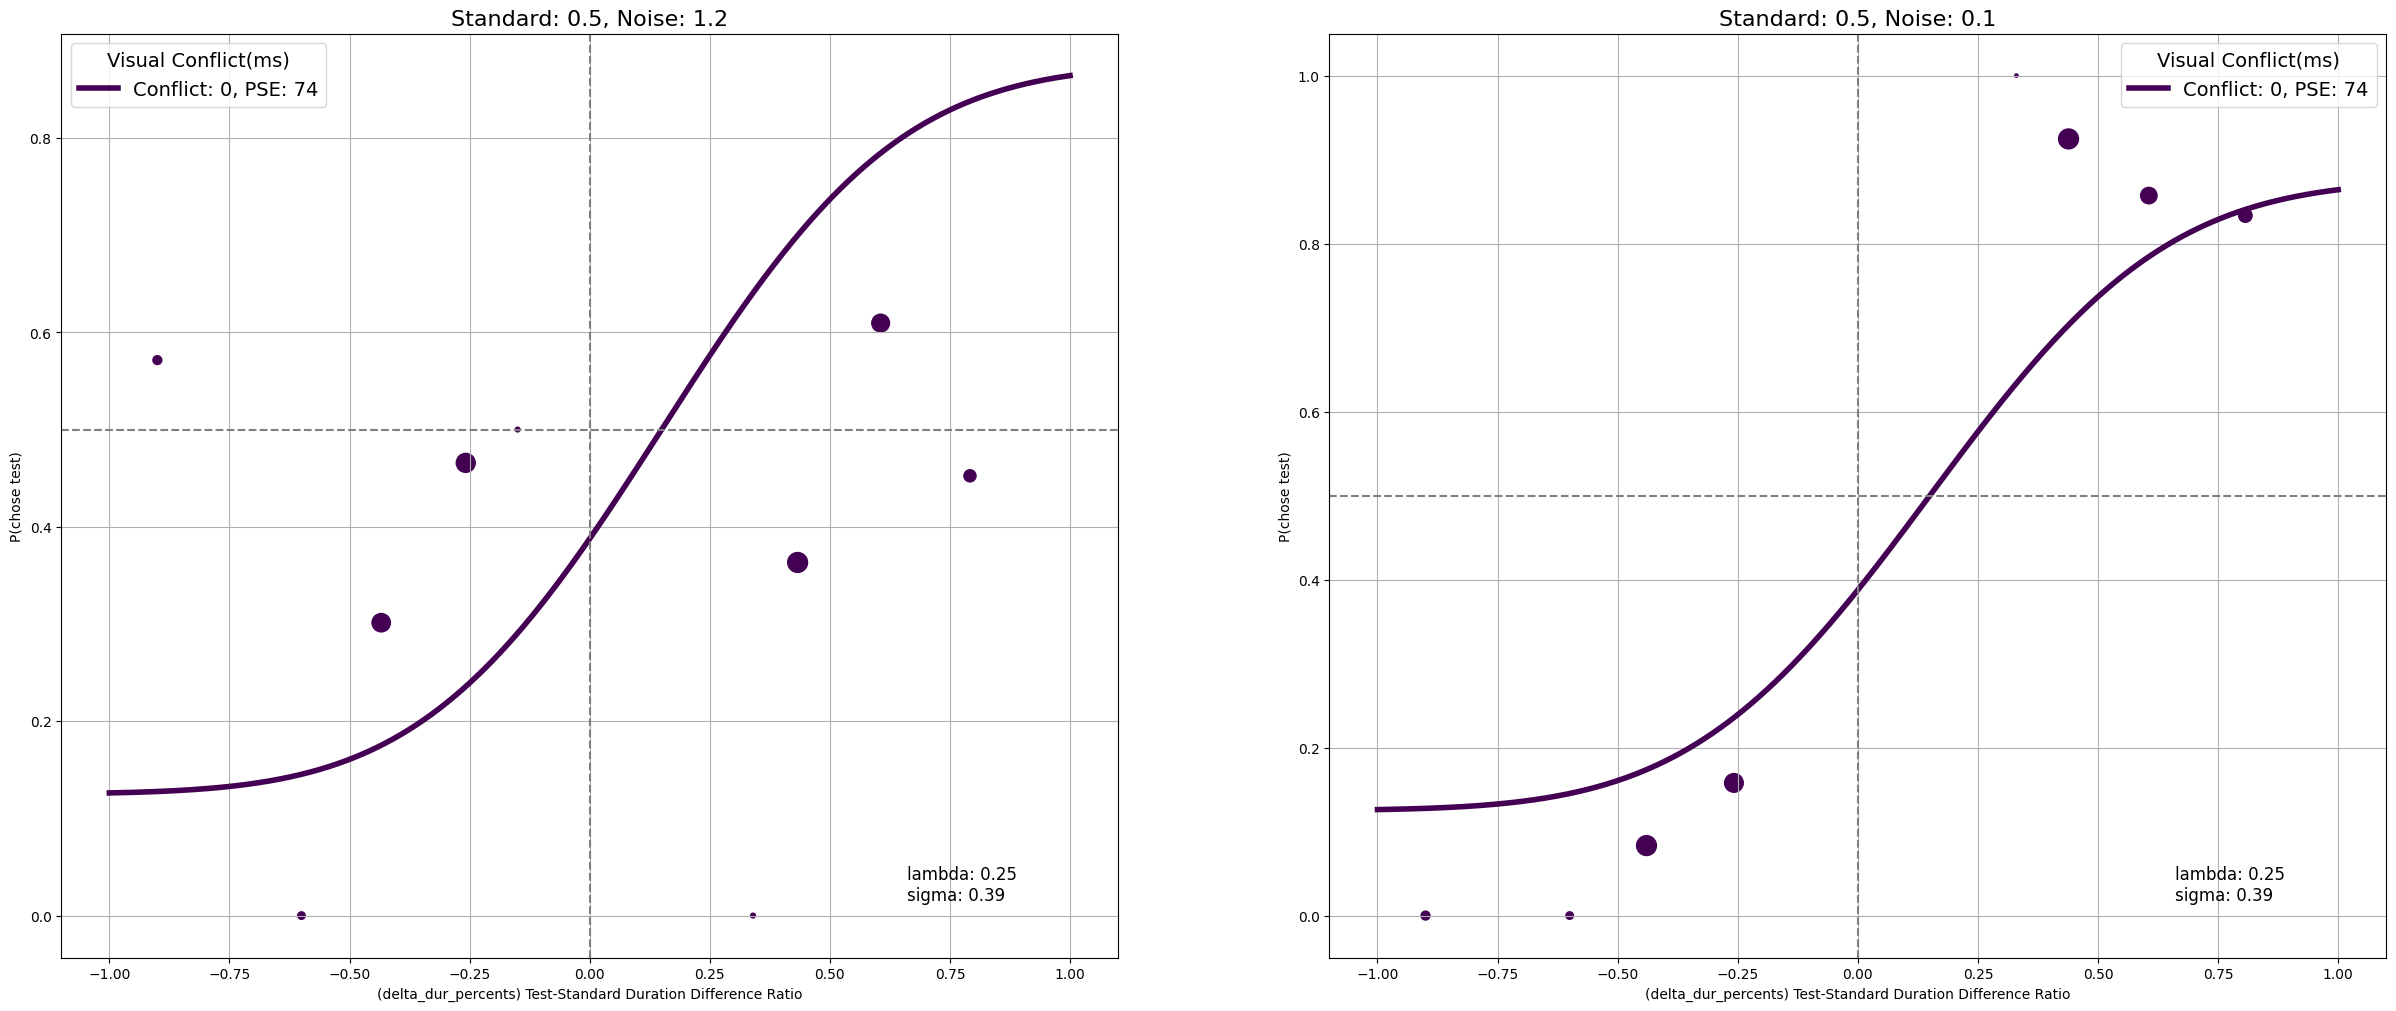

In [64]:
lambda_, mu, sigma = best_fit.x[:nLambda], best_fit.x[nLambda:nLambda+nSigma], best_fit.x[nLambda+nSigma:]
plt.figure(figsize=(12*2.5, 6*2))
for i, standardLevel in enumerate(uniqueStandard):
    print(f"fitted lambda: {lambda_}")
    for j, audioNoiseLevel in enumerate(uniqueSensory):
        for k, conflictLevel in enumerate(uniqueConflict):
            lambda_, mu, sigma = get_params(best_fit.x, conflictLevel, audioNoiseLevel, nLambda, nSigma)
            
            # Filter the data for the current standard and audio noise levels
            df=data[data[standardVar]==standardLevel]
            df=df[df[sensoryVar]==audioNoiseLevel]
            df=df[df[conflictVar]==conflictLevel]
            #print(f"fitting for standard: {standardLevel}, noise: {audioNoiseLevel}, conflict: {conflictLevel}")
            print(f"lambda: {lambda_:.3f}, mu: {mu:.3f}, sigma: {sigma:.3f}")
            dfFiltered=groupByChooseTest(df)
            levels = dfFiltered[intensityVariable].values
            if len(levels) == 0:
                continue
            responses = dfFiltered['num_of_chose_test'].values
            totalResponses = dfFiltered['total_responses'].values
            


            # Fit the psychometric function
            plt.subplot(1, 2, j+1)
            maxX= max(levels)+0.1
            minX= min(levels)-0.1
            #plt.ylim(0, 1)
            
            #plt.xlim(-1, maxX)
            x=np.linspace(minX, maxX, 500)
            y = psychometric_function(x, lambda_, mu, sigma)
            color=sns.color_palette("viridis", as_cmap=True)(k / len(uniqueConflict))  # Use a colormap for different conflict levels
            plt.plot(x, y, color=color, label=f"Conflict: {int(conflictLevel*1000)}, PSE: {int(mu/2*1000)}", linewidth=4)
            
            #plt.scatter(levels, responses/totalResponses, color=color) # plot real data
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel(f"({intensityVariable}) Test-Standard Duration Difference Ratio")
            plt.ylabel("P(chose test)")
            plt.title(f"Standard: {standardLevel}, Noise: {audioNoiseLevel}", fontsize=16)
            plt.legend(title="Visual Conflict(ms)", fontsize=14, title_fontsize=14)
            plt.grid()
            bin_and_plot(dfFiltered, bin_method='cut', bins=10, plot=True,color=color)
            plt.text( 0.8, 0.1, f"lambda: {lambda_:.2f}\nsigma: {sigma:.2f}", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)




fitted lambda: 0.06437512065208706


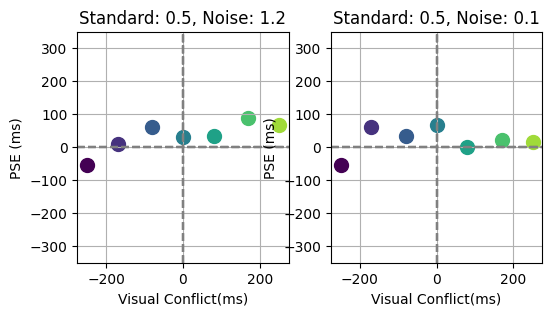

In [47]:

# New plot showing the relation between the conflict and pse so that conflict should be on x axis and pse(mu based on conflict level) on y axis
plt.figure(figsize=(6, 3))
m=0
for i, standardLevel in enumerate(uniqueStandard):
    print(f"fitted lambda: {lambda_}")
    for j, audioNoiseLevel in enumerate(uniqueSensory):
        for k, conflictLevel in enumerate(uniqueConflict):
            lambda_, mu, sigma = get_params(best_fit.x, conflictLevel, audioNoiseLevel, nLambda, nSigma)
            m+=1        
            plt.subplot(1, 2, j+1)
            color=sns.color_palette("viridis", as_cmap=True)(k / len(uniqueConflict))  # Use a colormap for different conflict levels
            plt.scatter(conflictLevel*1000, mu*1000/2, color=color, s=100) # plot real data
            plt.xlabel(f"Visual Conflict(ms)")
            plt.ylabel("PSE (ms)")
            plt.title(f"Standard: {standardLevel}, Noise: {audioNoiseLevel}")
            plt.grid()
            plt.axhline(y=0, color='gray', linestyle='--')
            plt.axvline(x=0, color='gray', linestyle='--')
            #plt.ylim(-300, 300)

            mu_idx = nLambda + nSigma + ((j) * len(uniqueConflict)) + k

            # select mus for allBootedFits
            #mu_all = allBootedFits[:, mu_idx]
            # calculate confidence intervals 95%
            #mu_ci = np.percentile(mu_all, [2.5, 97.5])
            # plot confidence intervals as error bars
            #plt.errorbar(conflictLevel*1000, mu*1000/2, yerr=[[mu*1000/2-mu_ci[0]*1000/2], [mu_ci[1]*1000-mu*1000]], fmt='o', color=color, capsize=10
            #             , label=f"95% CI for mu: {mu_ci[0]*1000:.2f} - {mu_ci[1]*1000/2:.2f}", linewidth=3)
            plt.ylim(-350, 350)

# Fit the psychometric function to the grouped data
#result = fit_psychometric_function(grouped, intensityVariable)

# 3- Bootstrap


In [36]:
def simulate_dataset(params, gdf):
    """
    Produce one synthetic data set that has the SAME predictors
    (delta, conflict, noise, total_responses) as 'gdf' but with
    binomially simulated response counts.
    """
    sim_gdf = gdf.copy()

    # vectorised computation to avoid Python loop
    lam   = np.empty(len(gdf))
    mu    = np.empty(len(gdf))
    sigma = np.empty(len(gdf))

    # Map each row's (conflict, noise) to its λ, μ, σ
    for idx, row in gdf.iterrows():
        lam_i, mu_i, sig_i = get_params(params,
                                        row[conflictVar],
                                        row[sensoryVar],
                                        nLambda,
                                        nSigma)
        lam[idx], mu[idx], sigma[idx] = lam_i, mu_i, sig_i

    p_choose_test = psychometric_function(sim_gdf[intensityVariable].values,
                                          lam, mu, sigma)

    # Binomial draw
    sim_gdf['num_of_chose_test'] = np.random.binomial(
        n = sim_gdf['total_responses'].values.astype(int),
        p = p_choose_test)

    return sim_gdf

def paramBootstrap(fitParams, nBoots):
    nBootParams = []
    # Add tqdm progress bar
    for _ in tqdm(range(nBoots), desc="Bootstrapping", unit="iteration"):
        #1- do simulation
        simData = simulate_dataset(fitParams, groupedData)
        # simulate data by taking binomials at this
        initGuessEstimate = estimate_initial_guesses(simData[intensityVariable].values, 
                                                    simData['num_of_chose_test'], 
                                                    simData['total_responses'])
        # fit the data to boot
        bootFit = fitJoint(grouped_data=simData, initGuesses=initGuessEstimate)

        # save
        nBootParams.append(bootFit.x)

    return np.vstack(nBootParams)

In [37]:
allBootedFits=paramBootstrap(best_fit.x,10)


Bootstrapping: 100%|██████████| 10/10 [04:23<00:00, 26.36s/iteration]


fitted lambda: 0.06437512065208706


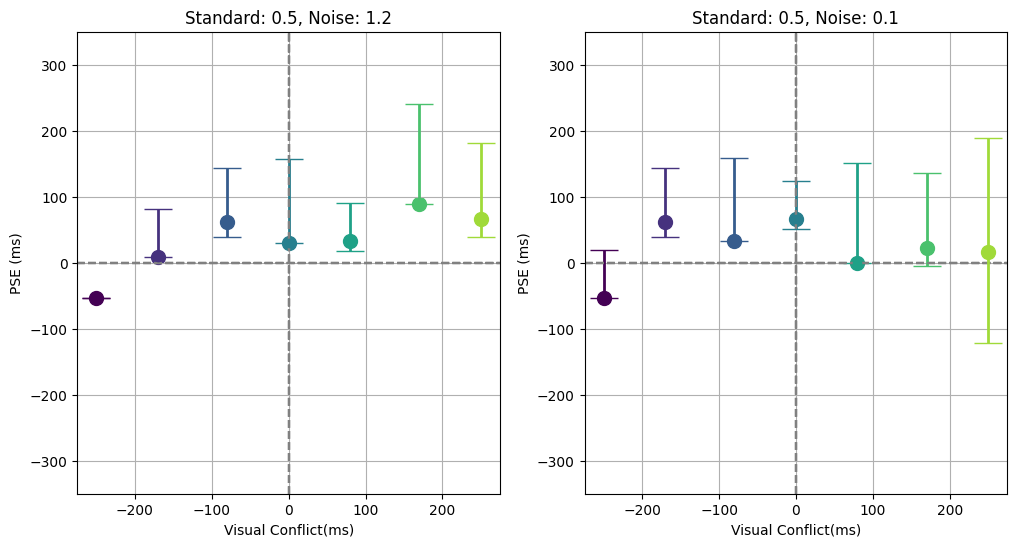

In [50]:

# New plot showing the relation between the conflict and pse so that conflict should be on x axis and pse(mu based on conflict level) on y axis
plt.figure(figsize=(12, 6))
m=0
for i, standardLevel in enumerate(uniqueStandard):
    print(f"fitted lambda: {lambda_}")
    for j, audioNoiseLevel in enumerate(uniqueSensory):
        for k, conflictLevel in enumerate(uniqueConflict):
            lambda_, mu, sigma = get_params(best_fit.x, conflictLevel, audioNoiseLevel, nLambda, nSigma)
            m+=1        
            plt.subplot(1, 2, j+1)
            color=sns.color_palette("viridis", as_cmap=True)(k / len(uniqueConflict))  # Use a colormap for different conflict levels
            plt.scatter(conflictLevel*1000, mu*1000/2, color=color, s=100) # plot real data
            plt.xlabel(f"Visual Conflict(ms)")
            plt.ylabel("PSE (ms)")
            plt.title(f"Standard: {standardLevel}, Noise: {audioNoiseLevel}")
            plt.grid()
            plt.axhline(y=0, color='gray', linestyle='--')
            plt.axvline(x=0, color='gray', linestyle='--')
            #plt.ylim(-300, 300)

            mu_idx = getParamIndexes(best_fit.x, conflictLevel, audioNoiseLevel, nLambda, nSigma)[1]

            # select mus for allBootedFits
            mu_all = allBootedFits[:, mu_idx]
            # calculate confidence intervals 95%
            mu_ci = np.percentile(mu_all, [2.5, 97.5])
            # plot confidence intervals as error bars
            lower_err = np.maximum(mu_ci[0]*1000/2, 0)
            upper_err = np.maximum(mu_ci[1]*1000/2, 0)
            plt.errorbar(conflictLevel*1000, mu*1000/2, yerr=[[lower_err], [upper_err]], fmt='o', color=color, capsize=10
                         , label=f"95% CI for mu: {mu_ci[0]*1000/2:.2f} - {mu_ci[1]*1000/2:.2f}", linewidth=2)
            plt.ylim(-350, 350)

# Fit the psychometric function to the grouped data
#result = fit_psychometric_function(grouped, intensityVariable)

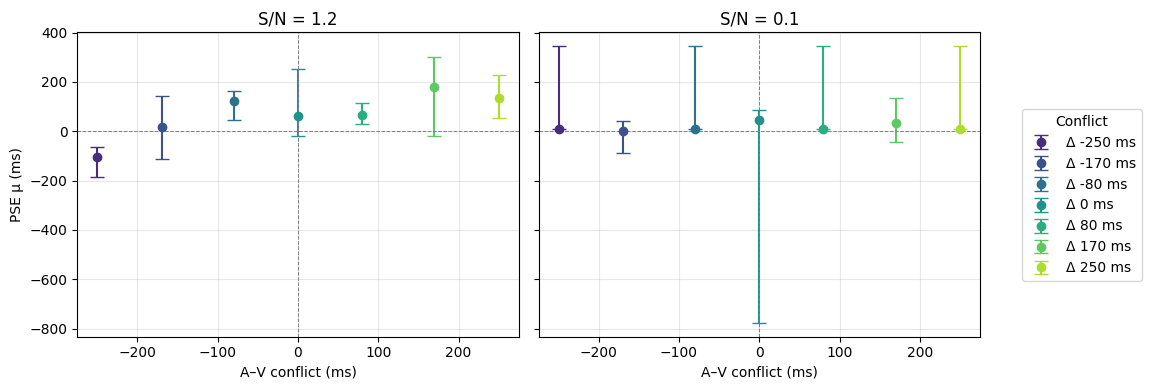

In [41]:
fig, ax = plt.subplots(1, len(uniqueSensory), figsize=(10,4), sharey=True)
palette = sns.color_palette("viridis", n_colors=len(uniqueConflict))

# build index once
mu_idx = {(n,c): nLambda+nSigma+i*len(uniqueConflict)+j
          for i,n in enumerate(uniqueSensory)
          for j,c in enumerate(uniqueConflict)}

for j, noise in enumerate(uniqueSensory):
    for k, conflict in enumerate(uniqueConflict):
        idx     = mu_idx[(noise, conflict)]
        mu_ms   = best_fit.x[idx] * 1e3
        mu_boot = allBootedFits[:, idx] * 1e3
        ci_low, ci_high = np.percentile(mu_boot, [2.5, 97.5])

        # Ensure yerr is non-negative
        lower_err = np.maximum(mu_ms - ci_low, 0)
        upper_err = np.maximum(ci_high - mu_ms, 0)
        ax[j].errorbar(conflict*1e3, mu_ms,
                       yerr=[[lower_err], [upper_err]],
                       fmt='o', color=palette[k], capsize=5,
                       label=f'Δ {conflict*1e3:.0f} ms' if j==0 else "")

    ax[j].set_title(f'S/N = {noise}')
    ax[j].set_xlabel('A–V conflict (ms)')
    ax[j].axhline(0, ls='--', c='grey', lw=.7)
    ax[j].axvline(0, ls='--', c='grey', lw=.7)
    ax[j].grid(alpha=.3)

ax[0].set_ylabel('PSE μ (ms)')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Conflict', bbox_to_anchor=(1.02,.5),
           loc='center left'); 
fig.tight_layout();  plt.show()
